In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import numpy as np
import random
import torch
import bayesflow as bf
import matplotlib.pyplot as plt
import pandas as pd
from keras import Model
from keras.layers import Dense, LSTM
from keras.initializers import RandomNormal

from data_utils import DataSimulator
from metrics import multimodel_accuracy
from losses import multimodel_exponential_loss
from Motion import *

INFO:bayesflow:Using backend 'torch'
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


In [2]:
print(f"Using Keras backend: {keras.backend.backend()}")

print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

np.random.seed(17)
random.seed(17)
torch.manual_seed(17)

Using Keras backend: torch
CUDA available: True
GPU device: NVIDIA GeForce RTX 4080 Laptop GPU


In [3]:
# Define simulator models
days = 100
time = days/365
steps = days

fc_simulator_geom = Motion("geom", "fc", time=time, num_steps=steps)
diag_simulator_geom = Motion("geom", "diag", time=time, num_steps=steps)
sph_simulator_geom = Motion("geom", "sph", time=time, num_steps=steps)
fc_simulator_arith = Motion("arith", "fc", time=time, num_steps=steps)
diag_simulator_arith = Motion("arith", "diag", time=time, num_steps=steps)
sph_simulator_arith = Motion("arith", "sph", time=time, num_steps=steps)


def norm_wrapper(sim):
    data = sim()['motion']
    data = np.clip(data, a_min=1e-8, a_max=None)
    log_ret = np.log(data[1:] / data[:-1])
    return log_ret

def x0(): 
    return 

brownian_models = [
    lambda s : [norm_wrapper(fc_simulator_geom) for _ in range(s)],
    lambda s : [norm_wrapper(diag_simulator_geom) for _ in range(s)],
    lambda s : [norm_wrapper(sph_simulator_geom) for _ in range(s)],
    lambda s : [norm_wrapper(fc_simulator_arith) for _ in range(s)],
    lambda s : [norm_wrapper(diag_simulator_arith) for _ in range(s)],
    lambda s : [norm_wrapper(sph_simulator_arith) for _ in range(s)]
]


In [4]:

x = np.array(brownian_models[1](4))

print(x.shape)

(4, 99, 3)


In [28]:
# Network
class BayesEvidenceNetwork(Model):
    def __init__(self, num_models, **kwargs):
        super().__init__(**kwargs)

        # shared backbone network
        self.summary_network = LSTM(128, return_sequences=False)
        self.classification_network = bf.networks.MLP(
            widths=[128] * 4, activation="silu", dropout=None)

        self.output_layer = Dense(num_models-1, activation=None,
                                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.01))  # unbounded

    def call(self, x, training=False):
        x = self.summary_network(x, training=training)
        x = self.classification_network(x, training=training)
        return self.output_layer(x)


In [32]:
# Data Preparation

BATCH_SIZE = 144
TRAIN_BATCHES = 144
VAL_BATCHES = 8
EPOCHS = 30

train_loader = DataSimulator(
    batches_per_epoch=TRAIN_BATCHES,
    simulators=brownian_models,
    batch_size=BATCH_SIZE,
)

# Validation loader
val_loader = DataSimulator(
    batches_per_epoch=VAL_BATCHES,
    simulators=brownian_models,
    batch_size=BATCH_SIZE,
)

In [33]:
# Compile model

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5, decay_steps=EPOCHS * len(train_loader)
)
optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule)

model = BayesEvidenceNetwork(len(brownian_models))

model.compile(
    optimizer=optimizer,
    loss=multimodel_exponential_loss,
    metrics=[multimodel_accuracy]
)

In [34]:
# Train model

with torch.enable_grad(): 
    history = model.fit(
        train_loader,
        validation_data=val_loader,
        epochs=EPOCHS,
        verbose=1
    )

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 45s 311ms/step - loss: 5.9959 - multimodel_accuracy: 0.2284 - val_loss: 5.9059 - val_multimodel_accuracy: 0.2908
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 44s 305ms/step - loss: 5.1779 - multimodel_accuracy: 0.2564 - val_loss: 4.9658 - val_multimodel_accuracy: 0.2587
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 78s 544ms/step - loss: 5.2249 - multimodel_accuracy: 0.2468 - val_loss: 5.5638 - val_multimodel_accuracy: 0.2300
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 74s 514ms/step - loss: 5.3008 - multimodel_accuracy: 0.2355 - val_loss: 5.0190 - val_multimodel_accuracy: 0.2587
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 44s 308ms/step - loss: 4.8748 - multimodel_accuracy: 0.2679 - val_loss: 4.8986 - val_multimodel_accuracy: 0.2648
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 301ms/step - loss: 5.2346 - multimodel_accuracy: 0.2409 - val_loss: 5.5887 - val_multimodel_accuracy: 0.2153
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 45s 313ms/step - loss: 5.4412 - multimodel

In [35]:
num_models = len(brownian_models)
cm = np.zeros((num_models, num_models), dtype=int)

# Fill confusion matrix
for idx, func in enumerate(brownian_models):
    X_test = np.array(func(100))
    y_test = np.full((X_test.shape[0], 1), idx, dtype=np.int32)

    f_x = model.predict(X_test[:, :], verbose=0)

    y_pred = np.argmax(f_x, axis=1)

    for true_label, pred_label in zip(y_test.flatten(), y_pred):
        cm[true_label, pred_label] += 1

    acc = np.mean(y_pred == y_test.flatten())
    print(f"Model {idx} accuracy: {acc*100:.2f}%")

# Pretty print confusion matrix
print("\nConfusion Matrix:")
header = "Predicted ->\t" + "\t".join([f"{i}" for i in range(num_models)])
print(header)
for i in range(num_models):
    row = "\t".join([str(cm[i, j]) for j in range(num_models)])
    print(f"True {i}:     \t{row}")

Model 0 accuracy: 74.00%
Model 1 accuracy: 0.00%
Model 2 accuracy: 0.00%
Model 3 accuracy: 0.00%
Model 4 accuracy: 0.00%
Model 5 accuracy: 0.00%

Confusion Matrix:
Predicted ->	0	1	2	3	4	5
True 0:     	74	0	0	0	26	0
True 1:     	79	0	0	0	21	0
True 2:     	84	0	0	0	16	0
True 3:     	100	0	0	0	0	0
True 4:     	100	0	0	0	0	0
True 5:     	100	0	0	0	0	0



Loss History


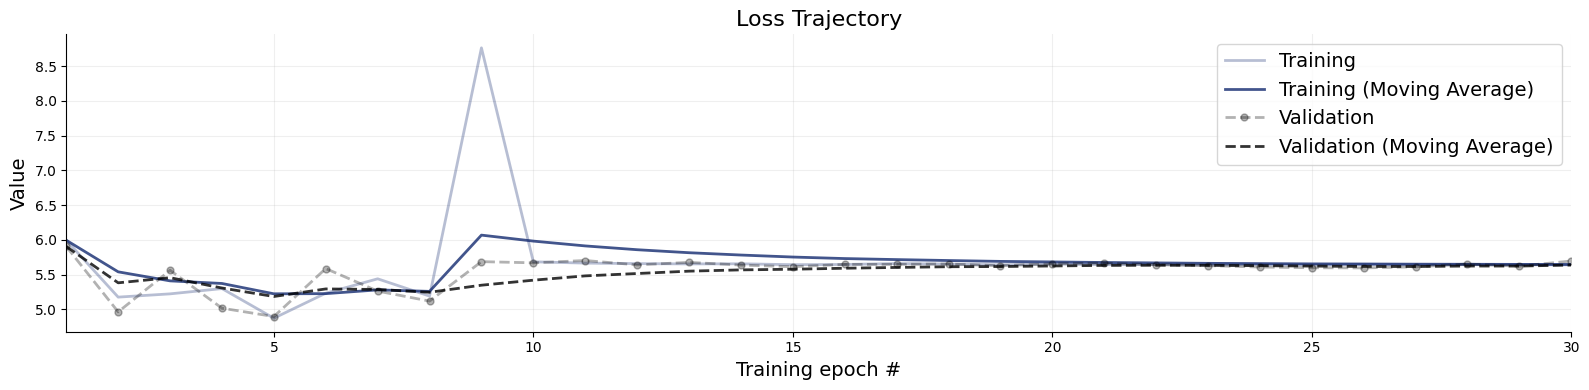

In [36]:
print(f"\nLoss History")
bf.diagnostics.plots.loss(history=history)
plt.show()